# Assignment 2 -- Deep Learning PhD course

We first prepare the playground for this report and import some packages and detect if there is a CUDA device in the machine.

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Here are two separate files which contain some useful functions for data loading

In [2]:
import data_handling as dh
import my_nn_pytorch as mnn
import my_plot_functions as mpf

# 1 Classification of hand-written digits using a Convolutional Neural Network

We first define the hyper parameters, which we are going to use in the following:

In [3]:
batch_size_train = 64         # batch size during training
batch_size_test = 1000       # batch size for the test data
lr_sgd = 1e-1                 # learning rate for Stochastic Gradient Descent (SGD)
nepochs = 10                  # number of epochs to run the training

The rational behind the choice of the parameters is the following:
1. ``batch_size_train``: we choose it small to avoid overfitting of the data even if it is computationally less efficient
2. ``batch_size_test``: we choose it large, since my GPU can handle it and I think that the evaluation should go faster if we run it all at once
3. ``lr_sgd``: I have observed that with this learning rate the training goes relatively fast and gives still good final accuracy

In [4]:
dataloader_train, dataloader_test = dh.init_MNIST(batch_size_train, batch_size_test)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
Shape of X for train data [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y for train data:  torch.Size([64]) torch.int64
Shape of X for test data [N, C, H, W]:  torch.Size([1000, 1, 28, 28])
Shape of y for test data:  torch.Size([1000]) torch.int64


## 1.1 Fully connected neural network

We have constructed a 

In [5]:
import ex11_fc_pytorch as fcp
fname = fcp.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = fcp.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(fcp.params2fname(nepochs, lr_sgd, batch_size_train))

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=98, bias=True)
    (1): ReLU()
    (2): Linear(in_features=98, out_features=98, bias=True)
    (3): ReLU()
    (4): Linear(in_features=98, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
  )
)


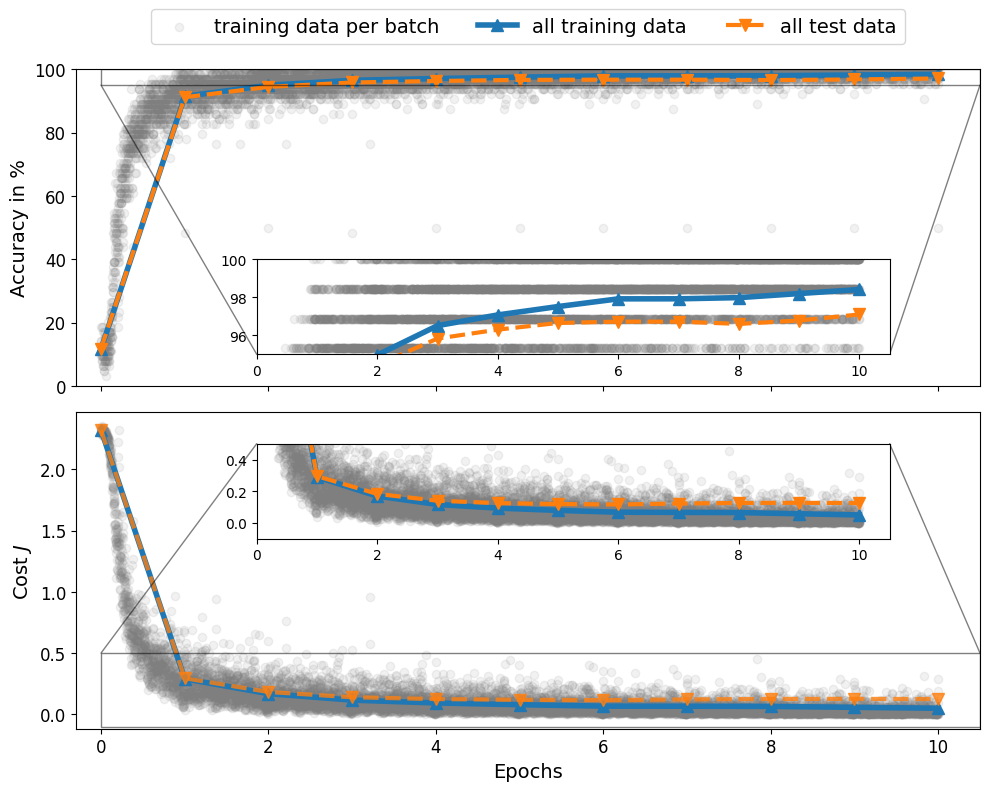

In [6]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

The final performance of the fully connected model after 10 epochs of training is an accuracy of 97.1% on the test data and the cost is 0.125. The model performs somewhat better on the training data, which could suggest a small over fitting problem.

In [7]:
mynn.print_epoch_info()

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TRAIN          !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:             10
! ITERATION:       9380
! COST:           0.050
! ACCURACY:       98.4%
!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TEST           !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:             10
! ITERATION:       9380
! COST:           0.125
! ACCURACY:       97.1%
!!!!!!!!!!!!!!!!!!!!!!!!!



The training of 10 epochs took about 340 seconds, that is 5 minutes and 40 seconds.

In [8]:
mynn.get_total_train_time()

339.6

## 1.2 Convolutional Neural Network

We build the following convolutional neural network:

| Layer | Function              | More detailed description                                | Output size | Number of parameters            |
|-------|-----------------------|----------------------------------------------------------|-------------|---------------------------------|
| 0     | Input                 | 28x28 px grey scale images                               | 1x28x28     | 0                               |
| 1     | Convolution           | 8 times 3x3x1 convolutions with stride 1 and padding 1   | 8x28x28     | (3\*3\*1+1)\*8 = 80      |
| 2     | ReLU                  | Non-linearity                                            | 8x28x28     | 0                               |
| 3     | Max Pooling           | 2x2 max pooling with stride 2                            | 8x14x14     | 0                               |
| 4     | Convolution           | 16 times 3x3x8 convolutions with stride 1 and padding 1  | 16x14x14    | (3\*3\*8+1\*16 = 1168   |
| 5     | ReLU                  | Non-linearity                                            | 16x14x14    | 0                               |
| 6     | Max Pooling           | 2x2 max pooling with stride 2                            | 16x7x7      | 0                               |
| 7     | Convolution           | 32 times 3x3x16 convolutions with stride 1 and padding 1 | 32x7x7      | (3\*3\*16+1\*32 = 4640  |
| 8     | ReLU                  | Non-linearity                                            | 32x7x7      | 0                               |
| 9     | Fully Connected       | 10 fully connected layer                                 | 10          | (32\*7\*7+1)\*10 = 15690 |
| 10    | Softmax               | Softmax layer                                            | 10          | 0                               |
| 11    | Classification Output | Crossentropy with 10 classes                             | 1           | 0                               |

The number of learnable parameters of the convolutional and fully connected layers can be computed as follows:
1. For a 3x3 convolution with stride 1 and padding 1 the lateral size of the images does not change. A single 3x3 convolution has 3\*3+1 learnable parameters (the weights of each pixel plus an additional bias). If we carry out $m$ of those in one layer, the number of weights becomes (3\*3+1)\*$m$. And if the input data to the layer was of dimension $l$ images, the number of parameters becomes (3\*3*$l$+1)\*$m$. This is the formula we have used to compute the number of learnable parameters.
2. A fully connected layer has ($n$+1)\*$m$ weights, where $n$ is the number of inputs and $m$ the number of outputs.

Adding the number of learnable parameters in the table, we find for the convolutional neural network we have built here a total of 80 + 1168 + 4640 + 15690 = 21578 learnable parameters. This is in contrast to the total number of weights in our fully connected network:

(28\*28+1)\*98 + (98+1)\*98 + (98+1)\*10 + (10+1)\*10 = 87732

We see that the convolutional network has only about one quarter of the number of parameters of the fully connected network, yet we observe better performance as we will see below.

In [9]:
import ex12_convnn_pytorch as cnnp
fname = cnnp.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnp.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnp.params2fname(nepochs, lr_sgd, batch_size_train))

NeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)


Here we plot the performance data of the convolutional network. We see that it reaches above 98% accuracy after about 2 epochs.

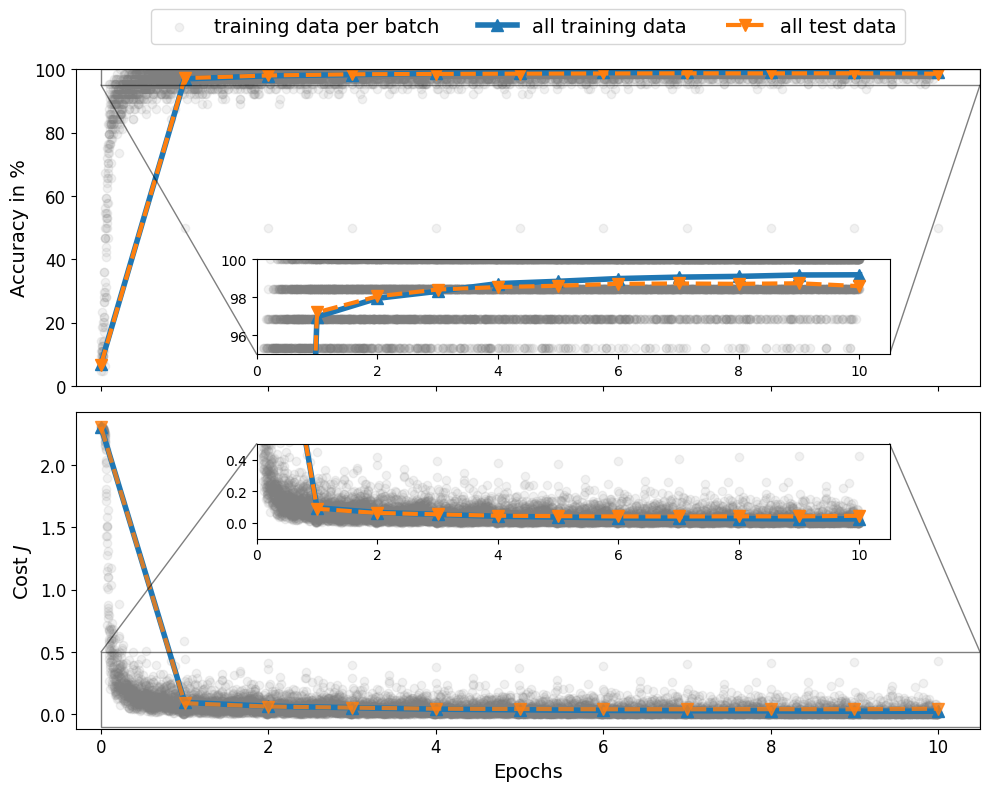

In [10]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network on the test data after 10 epochs is 98.6 % with a value of the cost function of 0.045. Thus the convolutional network performs significantly better than the fully connected model after 10 epochs of training. Also we observe a smaller discrepancy between the performance on the test data and the performance on the training data, suggesting that the model is more robust against overfitting.

In [11]:
mynn.print_epoch_info()

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TRAIN          !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:             10
! ITERATION:       9380
! COST:           0.025
! ACCURACY:       99.2%
!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TEST           !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:             10
! ITERATION:       9380
! COST:           0.045
! ACCURACY:       98.6%
!!!!!!!!!!!!!!!!!!!!!!!!!



The total training time of the convolutional model was about 390 seconds, i.e., 6 minutes and 30 seconds. The training took thus a bit longer than for the fully connected model. At first glance the result is a bit surprising, since we have fewer parameters to optimize, but each of the mathematical operations is more complex than the simple linear transformations in the fully connected model.

In [12]:
mynn.get_total_train_time()

389.5

## 1.3 Convolutional Neural Network with swapped order of activation function and Max pooling

### 1.3.1 Swapping the order of ReLU and max pooling

In [ ]:
import ex131_convnn_swaporder_relu_pytorch as cnnsr
fname = cnnsr.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnsr.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnsr.params2fname(nepochs, lr_sgd, batch_size_train))

NeuralNetwork(
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=10, bias=True)
  )
)
!!!!!!!!!!!!!!!!!!!!!!!!!
!        TRAIN          !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:              0
! ITERATION:          0
! COST:           2.304
! ACCURACY:        8.1%
!!!!!!!!!!!!!!!!!!!!!!!!!

!!!!!!!!!!!!!!!!!!!!!!!!!
!        TEST           !
!!!!!!!!!!!!!!!!!!!!!!!!!
! EPOCH:              0
! ITERATION:          0
! COST:           2.302
! ACCURACY:        8.5%
!!!!!!!!!!!!!!!!!!!!!!!!!

!!

Here we plot the performance data of the convolutional network. We see that it reaches above 98% accuracy after about 2 epochs.

In [ ]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network on the test data after 10 epochs is 98.7 % with a value of the cost function of 0.045. Thus the performace after swapping the order of ReLU activation and max pooling is the same as before.

In [ ]:
mynn.print_epoch_info()

The total train time is about 380 s, that is 10 s faster than before swapping the order.

In [ ]:
mynn.get_total_train_time()

### 1.3.2 Building a convolutional neural network with tanh activation

Here we build a convolutional network with tanh activation function and train it with the usual parameters.

In [ ]:
import ex132_convnn_tanh_pytorch as cnnt
fname = cnnt.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnt.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnt.params2fname(nepochs, lr_sgd, batch_size_train))

In [ ]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

The final accuracy of our convolutional network with Tanh activation is 98.7 % with a value of the cost function of 0.037 on the test data after 10 epochs. Thus the performace  is similar to the network with the ReLU activation.

In [ ]:
mynn.print_epoch_info()

Surprisingly, the convolutional network with Tanh activation took less time to train than the one with ReLU. This seems strange, since the Tanh activation function is more costly to compute than the ReLU activation and should thus lead to longer run time. Maybe we have here a measuring error or I have loaded the computer in some otehr way during the training of the network making use of the ReLU activation.

In [ ]:
mynn.get_total_train_time()

### 1.3.3 Swapping the order of tanh activation and max pooling

We now repeat the swapping procedure for the tanh activation function. The resulting network is trained using the usual hyper parameters:

In [ ]:
import ex133_convnn_swaporder_tanh_pytorch as cnnst
fname = cnnst.params2fname(nepochs, lr_sgd, batch_size_train, )
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnst.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnst.params2fname(nepochs, lr_sgd, batch_size_train))

In [ ]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

In [ ]:
mynn.print_epoch_info()

In [ ]:
mynn.get_total_train_time()

### 1.3.4 Summary on the effect of swapping the order of activation function and max pooling

Our results here show, that the performance of the model is unchanged by swapping the order of max pooling and the activation function. However, the time it takes to train the model is affected by the order. Having the activation before the max pooling operation results in a longer training time. This can be explained by the fact, that if the max pooling is performed first, the activation function is applied to a smaller amount of data points. Conversely, max pooling is in both cases performed on the same amount of data points, so there is not speed up associated with swapping the order.

## 1.4 Convolutional Neural Network

We now use the Adam optimizer instead of the plain SGD algorithm. 

## 1.4.1 Naive swap of optimizer

In [ ]:
import ex131_convnn_swaporder_relu_pytorch as cnnsr
fname = cnnsr.params2fname(nepochs, lr_sgd, batch_size_train, 'adam')
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnsr.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_sgd)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnsr.params2fname(nepochs, lr_sgd, batch_size_train, 'adam'))

betas=(0.9, 0.999), eps=1e-08

In [ ]:
print(optimizer)

In [ ]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

In [ ]:
mynn.print_epoch_info()

In [ ]:
mynn.get_total_train_time()

### 1.4.2 Adapting the learning rate

In [ ]:
lr_adam = 1e-2

In [ ]:
import ex131_convnn_swaporder_relu_pytorch as cnnsr
fname = cnnsr.params2fname(nepochs, lr_adam, batch_size_train, 'adam')
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnsr.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnsr.params2fname(nepochs, lr_adam, batch_size_train, 'adam'))

In [ ]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

In [ ]:
mynn.print_epoch_info()

In [ ]:
mynn.get_total_train_time()

Now we compare to the case where we have a smaller learning rate in the SGD algorithm:

In [ ]:
import ex131_convnn_swaporder_relu_pytorch as cnnsr
fname = cnnsr.params2fname(nepochs, lr_adam, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnsr.NeuralNetwork()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnsr.params2fname(nepochs, lr_adam, batch_size_train))

In [ ]:
fig, axs, axins = mpf.plot_acc_cost(mynn.perflog2pandas(), len(mynn.dataloader_train))

In [ ]:
mynn.print_epoch_info()

In [ ]:
print('Total train time was %.0f s' % mynn.get_total_train_time())

## 1.5 Improving the model

### 1.5.1 

### 1.5.2 

### 1.5.3 

# 2 Semantic segmentation of Biomedical images

In [ ]:
batch_size_train = 4          # batch size during training
batch_size_test = 32          # batch size for the test data
lr_adam = 1e-2                # learning rate for Stochastic Gradient Descent (SGD)
nepochs = 10                  # number of epochs to run the training

In [ ]:
import ex21_convnn_warwick_pytorch as cnnww
fname = cnnww.params2fname(nepochs, lr_adam, batch_size_train)
try:
    mynn = mnn.load_nn(fname)
    print(mynn.model)
except FileNotFoundError:
    model = cnnww.NeuralNetwork()
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_adam)
    mynn = mnn.MyNeuralNetwork(model, loss_fn, optimizer, dataloader_train, dataloader_test, device=device)
    mynn.train(nepochs=nepochs)
    mynn.to_disk(cnnww.params2fname(nepochs, lr_adam, batch_size_train))